In [1]:
import math as m
import cv2 
import numpy as np
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt

class Fast_LBP():
	def __init__(self, radius=1, neighbors=8):
		self._radius = radius
		self._neighbors = neighbors
	@property
	def radius(self):
		return self._radius
	@property
	def neighbors(self):
		return self._neighbors		
	def Compute_LBP(self,Image):
		#Determine the dimensions of the input image.
		ysize, xsize = Image.shape
		# define circle of symetrical neighbor points
		angles_array = 2*np.pi/self._neighbors
		alpha = np.arange(0,2*np.pi,angles_array)
		# Determine the sample points on circle with radius R
		s_points = np.array([-np.sin(alpha), np.cos(alpha)]).transpose()
		s_points *= self._radius
		# s_points is a 2d array with 2 columns (y,x) coordinates for each cicle neighbor point		
		# Determine the boundaries of s_points wich gives us 2 points of coordinates
		# gp1(min_x,min_y) and gp2(max_x,max_y), the coordinate of the outer block 
		# that contains the circle points
		min_y=min(s_points[:,0])
		max_y=max(s_points[:,0])
		min_x=min(s_points[:,1])
		max_x=max(s_points[:,1])
		# Block size, each LBP code is computed within a block of size bsizey*bsizex
		# so if radius = 1 then block size equal to 3*3
		bsizey = np.ceil(max(max_y,0)) - np.floor(min(min_y,0)) + 1
		bsizex = np.ceil(max(max_x,0)) - np.floor(min(min_x,0)) + 1
		# Coordinates of origin (0,0) in the block
		origy =  int(0 - np.floor(min(min_y,0)))
		origx =  int(0 - np.floor(min(min_x,0)))
		#Minimum allowed size for the input image depends on the radius of the used LBP operator.
		if xsize < bsizex or ysize < bsizey :
			raise Exception('Too small input image. Should be at least (2*radius+1) x (2*radius+1)')
		# Calculate dx and dy: output image size
		# for exemple, if block size is 3*3 then we need to substract the first row and the last row which is 2 rows
		# so we need to substract 2, same analogy applied to columns
		dx = int(xsize - bsizex + 1)
		dy = int(ysize - bsizey + 1)
		# Fill the center pixel matrix C.
		C = Image[origy:origy+dy,origx:origx+dx]
		# Initialize the result matrix with zeros.
		result = np.zeros((dy,dx), dtype=np.float32)
		for i in range(s_points.shape[0]):
			# Get coordinate in the block:
			p = s_points[i][:]
			y,x = p + (origy, origx)
			# Calculate floors, ceils and rounds for the x and ysize
			fx = int(np.floor(x))
			fy = int(np.floor(y))
			cx = int(np.ceil(x))
			cy = int(np.ceil(y))
			rx = int(np.round(x))
			ry = int(np.round(y))
			D = [[]]
			if np.abs(x - rx) < 1e-6 and np.abs(y - ry) < 1e-6:
			#Interpolation is not needed, use original datatypes
				N = Image[ry:ry+dy,rx:rx+dx]
				D = (N >= C).astype(np.uint8)
			else:
				# interpolation is needed
				# compute the fractional part.
				ty = y - fy
				tx = x - fx
				# compute the interpolation weight.
				w1 = (1 - tx) * (1 - ty)
				w2 = tx * (1 - ty)
				w3 = (1 - tx) * ty
				w4 = tx * ty
				# compute interpolated image:
				N = w1*Image[fy:fy+dy,fx:fx+dx]
				N = np.add(N, w2*Image[fy:fy+dy,cx:cx+dx], casting="unsafe")
				N = np.add(N, w3*Image[cy:cy+dy,fx:fx+dx], casting="unsafe")
				N = np.add(N, w4*Image[cy:cy+dy,cx:cx+dx], casting="unsafe")
				D = (N >= C).astype(np.uint8)
			#Update the result matrix.
			v = 2**i
			result += D*v
		return result.astype(np.uint8)

In [2]:
class features_extraction():
    def __init__(self, lbp, grid_size = (8,8)):
        self._lbp = lbp
        self._grid_size = grid_size
    def lbp_histograms(self, image):
        # compute the lbp of the image
        LBP = self._lbp.Compute_LBP(image)
        print(LBP)
        # divide the lbp imgae into small regions
        LBP_height, LBP_width = LBP.shape
        Grid_rows, Grid_cols = self._grid_size
        row_number = int(LBP_height/Grid_rows)
        col_number = int(LBP_width/Grid_cols)
        features = []
        for row in range(0,Grid_rows):
            cv2.line(image, (int(row*row_number),0), (int(row*row_number),255), (0, 0, 0) , 2) 
            cv2.line(image, (0,int(row*row_number)), (255,int(row*row_number)), (0, 0, 0) , 2)
            for col in range(0,Grid_cols):
                Chunk_LBP = LBP[row*row_number:(row+1)*row_number,col*col_number:(col+1)*col_number]
                #compute the histogram for each region
                (Histogram, bins) = np.histogram(Chunk_LBP, bins=2**8,
                 range=(0, 2**8))
                width = bins[1] - bins[0]
                center = (bins[:-1] + bins[1:]) / 2
                axs[row][col].bar(center, Histogram, align='center', width=width)
                np.append(features, Histogram, 0)
                print(row)
        return np.asarray(features)

[[155 155 156 ... 149 149 148]
 [154 155 156 ... 150 149 148]
 [154 154 154 ... 150 149 149]
 ...
 [164 164 164 ...  33  33  33]
 [165 153 135 ...  33  33  33]
 [105  78  41 ...  33  33  33]]
[[  7   7  31 ... 253 112 124]
 [255 127  14 ... 112 252 253]
 [127  30 127 ... 253 240 249]
 ...
 [252 255 227 ... 255 255 255]
 [ 17  17  16 ... 255 255 255]
 [ 30  30  30 ... 255 255 255]]
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7


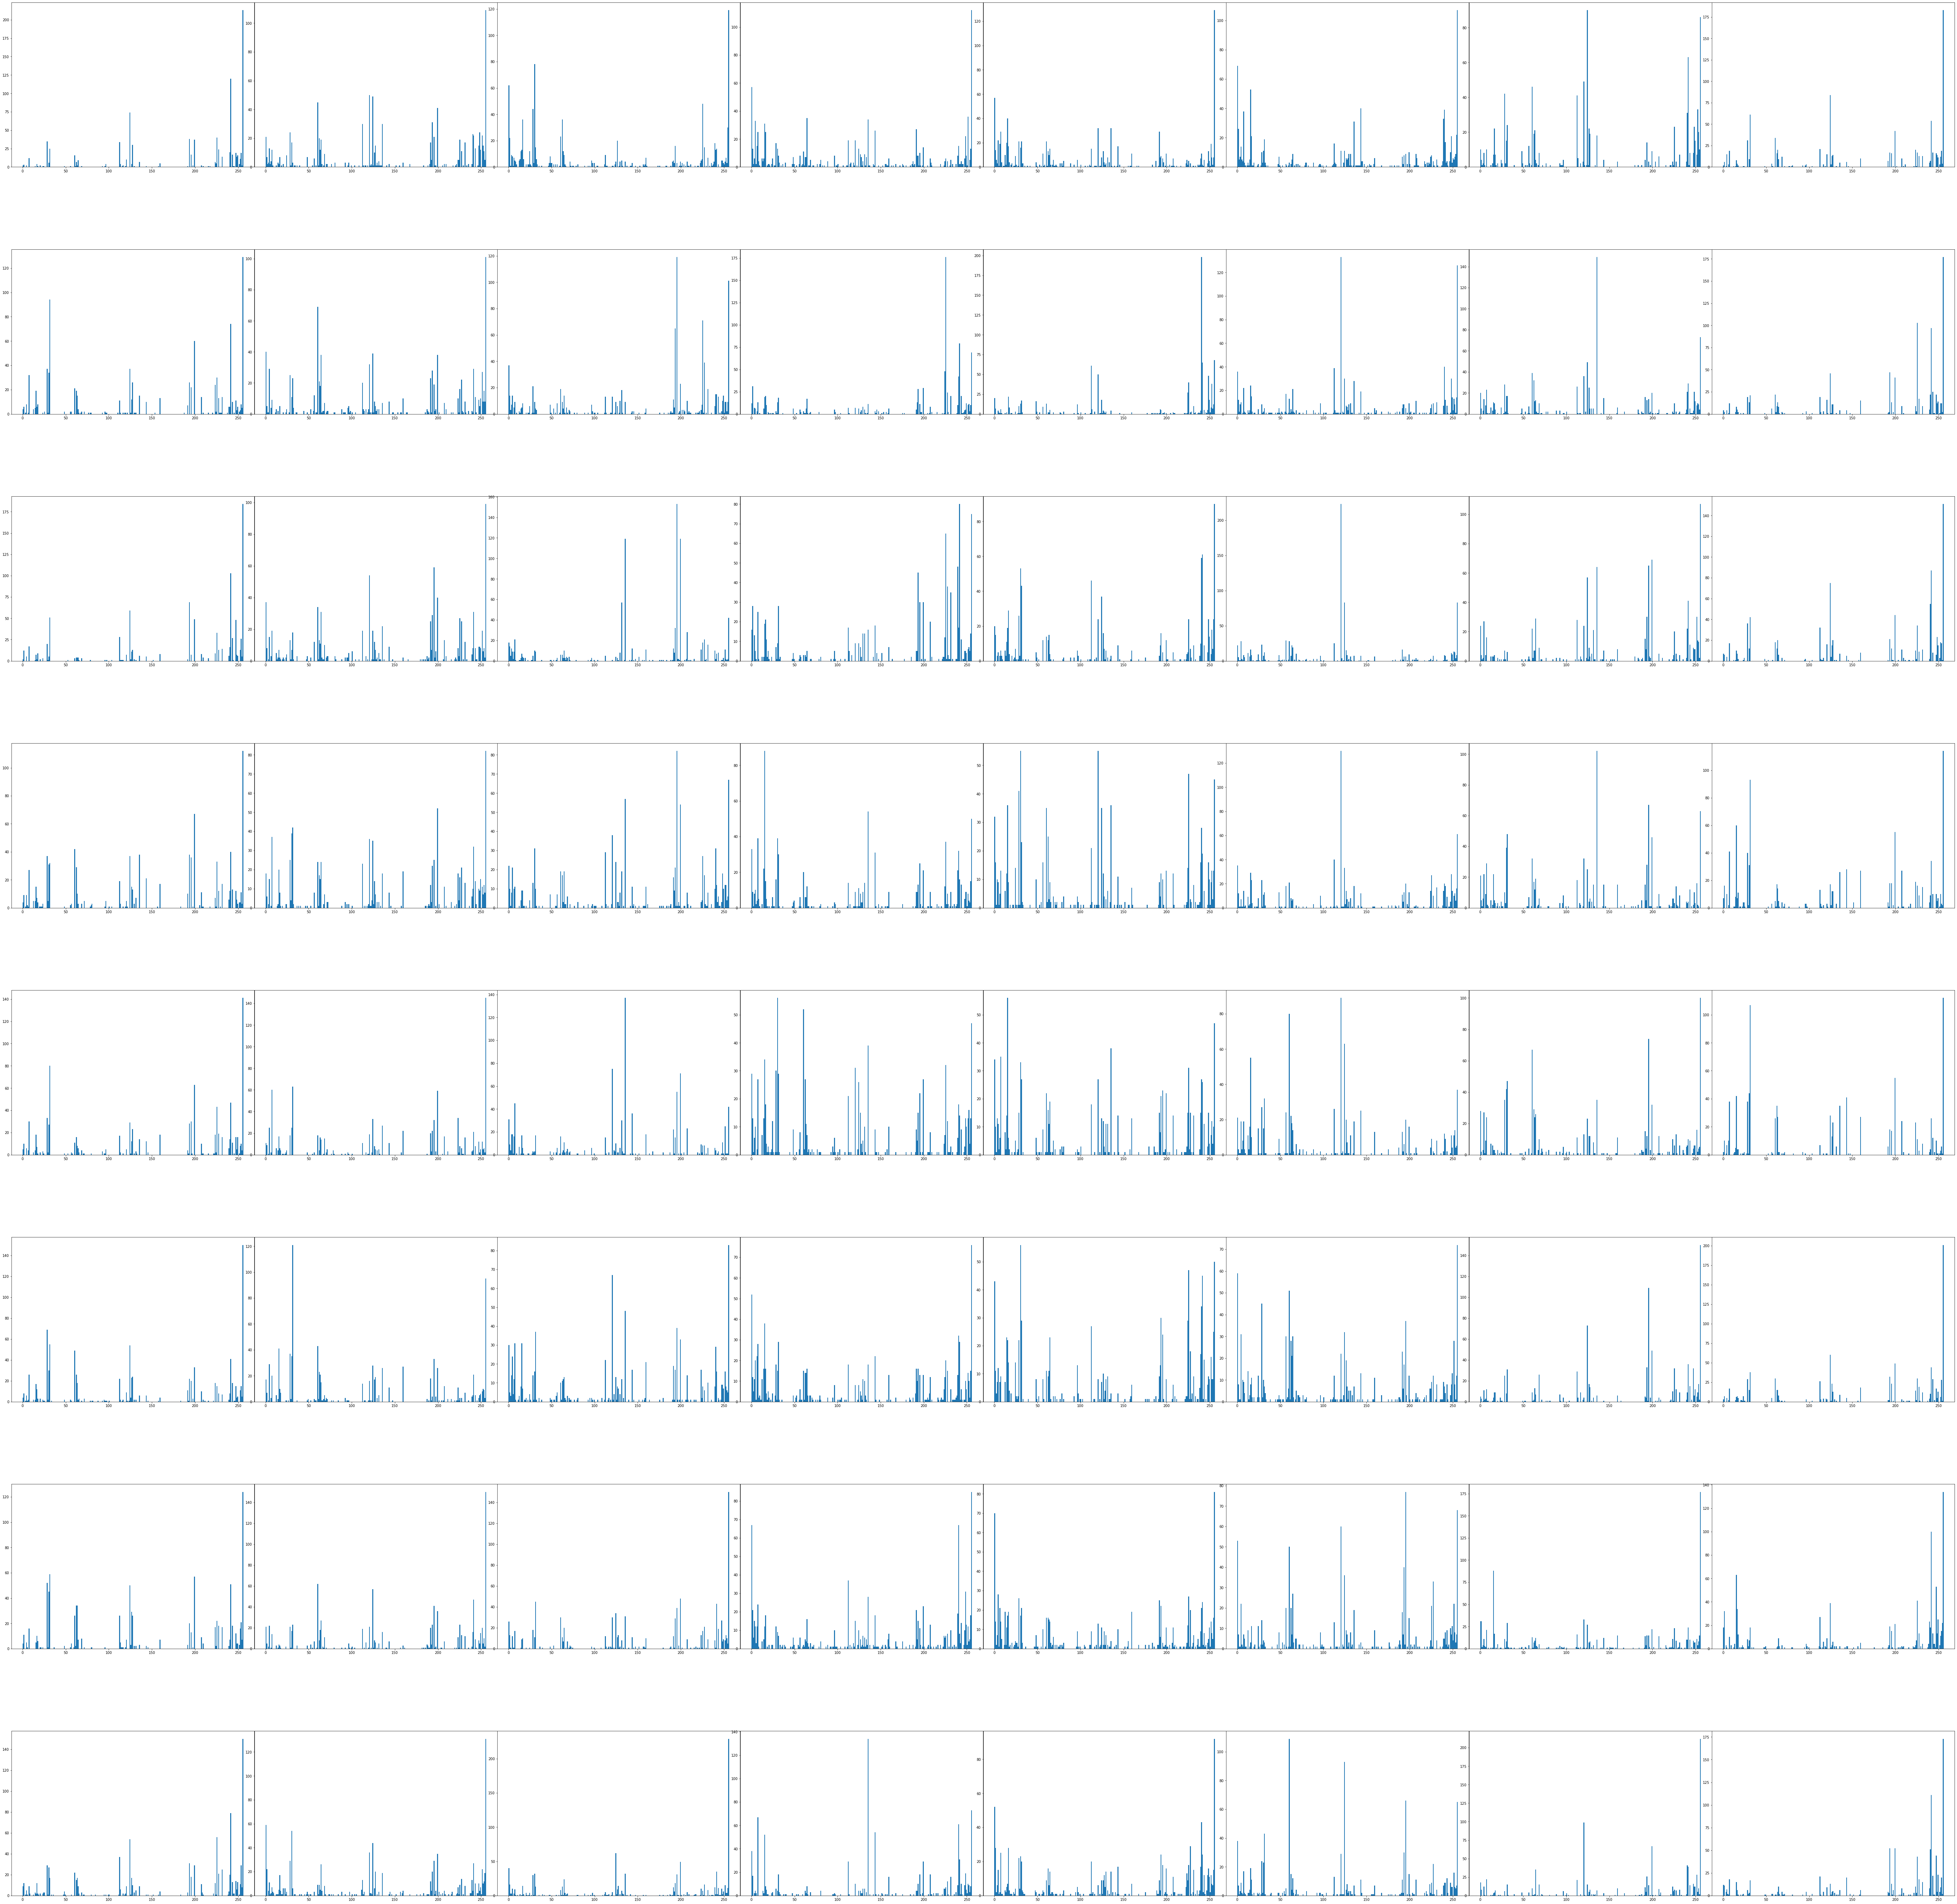

In [3]:
img = np.array(cv2.imread("images/img3.jpg",cv2.IMREAD_GRAYSCALE), 'uint8')
print(img)
fig, axs = plt.subplots(8,8, figsize=(100,100), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

lbp = Fast_LBP(1,8)
features_extraction = features_extraction(lbp)
features_extraction.lbp_histograms(img)

plt.show()
cv2.imshow('image', img)
if cv2.waitKey(0) & 0xFF == ord("q"):
    pass    


# Trial 2

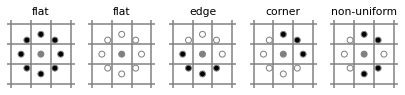

In [1]:
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

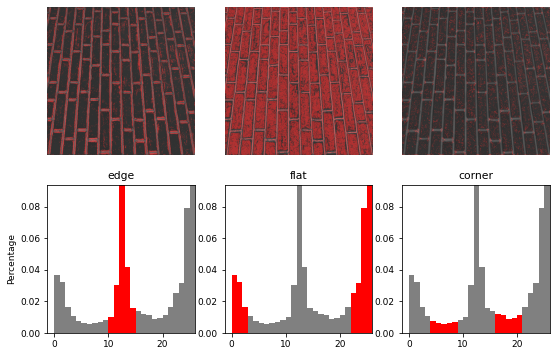

In [2]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Trial 3

In [1]:
# import the necessary packages
from skimage import feature
import numpy as np
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

ModuleNotFoundError: No module named 'skimage'

In [2]:
#from pyimagesearch.localbinarypatterns import LocalBinaryPatterns
from sklearn.svm import LinearSVC
from imutils import paths
import argparse
import cv2
import os
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-t", "--training", required=True,
	help="path to the training images")
ap.add_argument("-e", "--testing", required=True, 
	help="path to the tesitng images")
args = vars(ap.parse_args())
# initialize the local binary patterns descriptor along with
# the data and label lists
desc = LocalBinaryPatterns(24, 8)
data = []
labels = []

usage: ipykernel_launcher.py [-h] -t TRAINING -e TESTING
ipykernel_launcher.py: error: the following arguments are required: -t/--training, -e/--testing


SystemExit: 2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
